<a href="https://colab.research.google.com/github/MoustHolmes/AMAS_Project/blob/main/DDPG_LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip3 install box2d-py

     |████████████████████████████████| 450kB 6.2MB/s 


In [2]:
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from gym.wrappers import Monitor

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [3]:
# ja jeg har tyv stjålet dette
# og nej jeg har ingen anse om hvad det gør men det virker!
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Imports

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg
import gym
from gym import spaces, logger
from gym.utils import seeding

import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Enviroment

# Networks

In [ ]:
# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [5]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content/gdrive/My Drive'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        model_save_name = name + '_2.pt'
        # self.path = F"/content/gdrive/My Drive/{model_save_name}" 
        self.checkpoint_dir = F"/content/gdrive/My Drive/{model_save_name}"
        # self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        
        self.q = nn.Linear(self.fc2_dims, 1)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        #state_value = F.relu(state_value)
        #action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        #state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        # T.save(self.state_dict(), self.path)
        # T.save(self.state_dict(), self.checkpoint_file)
        T.save(self.state_dict(), self.checkpoint_dir)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_dir))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content/gdrive/My Drive'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        model_save_name = name + '_2.pt'
        # self.path = F"/content/gdrive/My Drive/{model_save_name}" 
        self.checkpoint_dir = F"/content/gdrive/My Drive/{model_save_name}"
        # self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        # T.save(self.state_dict(), self.checkpoint_file)
        T.save(self.state_dict(), self.checkpoint_dir)#changed file to dir 

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_dir))#changed file to dir

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)


# Noise

In [6]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

#Replay Buffer

In [7]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

# Agent

note that i can outcomment the setting the terminal flag to zero if the reward scheme only gives negative rewards 


In [8]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, n_actions, output_bounds, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300, 
                 batch_size=256,
                 noise_sigma = 0.15):
      #output bounds are my addition 
        self.output_bounds = output_bounds
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        # self.noise_sigma = noise_sigma

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        #we have  to scale the noise to match the outpu bounds

        var_names = str(alpha) +'_'+ str(beta) +'_'+ str(gamma) +'_' +str(fc1_dims) +'_'+ str(fc2_dims) +'_'+ str(noise_sigma)

        self.noise = OUActionNoise(mu=np.zeros(n_actions), sigma = noise_sigma *output_bounds)

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='actor' +var_names)
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='critic' +var_names)

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_actor' +var_names)

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_critic' +var_names)

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), 
                                    dtype=T.float).to(self.actor.device)
        self.actor.train()

        return mu_prime.cpu().detach().numpy()[0]*self.output_bounds

    def choose_action_no_noise(self, observation):#my addition
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        return mu.cpu().detach().numpy()[0]*self.output_bounds

    def choose_action_no_noise_batch(self, observation):#my addition
        self.actor.eval()
        state = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state)#.to(self.actor.device)
        return mu.cpu().detach().numpy()*self.output_bounds

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        # critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        #self.target_critic.load_state_dict(critic_state_dict, strict=False)
        #self.target_actor.load_state_dict(actor_state_dict, strict=False)

# Utils

In [9]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [10]:
env = gym.make('LunarLander-v2')

# Main

In [21]:
# env = CartPoleEnv(use_theta_threshold=True)

env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.000025, beta=0.00025, 
                input_dims=env.observation_space.shape, output_bounds=20,
                tau=0.001,
                batch_size=64, fc1_dims=400, fc2_dims=300, 
                n_actions=4)
# agent.load_models()
n_games = 15000

n_steps=200

filename = 'Cartpole_DDPG_alpha_' + str(agent.alpha) + '_beta_' + \
            str(agent.beta) + '_' + str(n_games) + '_games'
figure_file =  filename + '.png'

best_score = env.reward_range[0]
score_history = []
score_action_history = []

In [23]:
# agent.load_models()
n_games=20000
for i in range(n_games):
    observation = env.reset()
    # print(observation.shape)
    # print(observation)
    done = False
    score = 0
    agent.noise.reset()
    k=0
    while not done:
        # env.render()
        k+=1
        
        action = agent.choose_action(observation)

        # print(action)
        observation_, reward, done, info = env.step(action)
        # print(observation_.shape) 
        # print(observation_)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
        if k>n_steps:
            done=True
    score_history.append(score)
    score_action_history.append(score/k)
    
    avg_score = np.mean(score_history[-100:])
    avg_action_score = np.mean(score_action_history[-100:])

    if avg_score > best_score and i > 80:
        best_score = avg_score
        # agent.save_models()

    print('episode ', i, 'score %.1f' % score,'episode length ',k,
            'average score %.1f' % avg_score, 'best score:%.1f' %best_score)
    
    # if avg_action_score > best_score and i > 30:
    #     best_score = avg_action_score
    #     agent.save_models()
    
    # print('episode ', i, 'score %.1f' % score_action_history[-1],'episode length ',k,
    #         'average score %.1f' % avg_action_score)
# env.close() 
# x = [i+1 for i in range(len((score_history))]
# plot_learning_curve(x, score_history, figure_file)


episode  0 score -544.8 episode length  80 average score -544.5 best score:-551.4
episode  1 score -143.7 episode length  90 average score -540.2 best score:-551.4
episode  2 score -125.4 episode length  79 average score -532.0 best score:-551.4
episode  3 score -117.0 episode length  68 average score -526.2 best score:-551.4
episode  4 score -140.6 episode length  88 average score -516.4 best score:-551.4
episode  5 score -93.2 episode length  65 average score -516.5 best score:-551.4
episode  6 score -172.6 episode length  78 average score -509.5 best score:-551.4
episode  7 score -192.8 episode length  103 average score -510.0 best score:-551.4
episode  8 score -508.8 episode length  110 average score -514.2 best score:-551.4
episode  9 score -567.1 episode length  73 average score -519.4 best score:-551.4
episode  10 score -351.9 episode length  84 average score -521.8 best score:-551.4
episode  11 score -563.3 episode length  91 average score -515.8 best score:-551.4
episode  12 s

KeyboardInterrupt: ignored

162.9001428243622


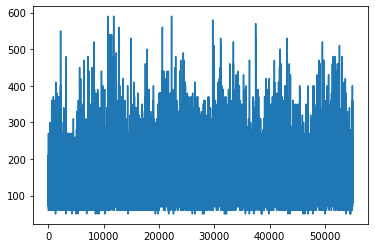

In [ ]:
print(best_score)
plt.plot(np.arange(len(score_history)),score_history)

[[  0.     1.     0.     0.  ]
 [  0.     0.    -0.98   0.  ]
 [  0.     0.     0.     1.  ]
 [  0.     0.   -21.56   0.  ]]


# Sweep

In [ ]:
env = CartPoleEnv(use_theta_threshold=True)

n_sweeps = 20

n_games = 12000

n_steps=200

noise_sigma_list = []
fc1_list = []
fc2_list = []
alpha_list = []
beta_list = []

best_score_list = []

for j in range(n_sweeps):


  noise_sigma = np.random.choice([1, 0.5, 0.1, 0.05, 0.01])
  fc1 = np.random.choice([400, 300, 200, 100, 70, 50])
  fc2 = np.random.choice([400, 300, 200, 100, 70, 50])
  alpha = np.random.choice([0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001])
  beta = np.random.choice([0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001])

  # str(alpha) +'_'+ str(beta) +'_'+ str(gamma) +'_' +str(fc1_dims) +'_'+ str(fc2_dims) +'_'+ str(noise_sigma)
  alpha = 0.0001
  beta = 0.001
  gamma = 0.99
  fc1 = 300
  fc2 = 100
  noise_sigma = 0.2

  print(n_sweeps)
  print('noise_sigma: ',noise_sigma)
  print('fc1 ',fc1)
  print('fc2 ',fc2)
  print('alpha ', alpha)
  print('beta ',beta)



  noise_sigma_list.append(noise_sigma)
  fc1_list.append(fc1)
  fc2_list.append(fc2)
  alpha_list.append(alpha)
  beta_list.append(beta)

  agent = Agent(alpha=alpha, beta=beta, 
                  input_dims=env.observation_space.shape, output_bounds=15,
                  tau=0.001,
                  fc1_dims=fc1, fc2_dims=fc2, 
                  n_actions=1,
                  noise_sigma = noise_sigma)

  # agent.load_models()


  best_score = env.reward_range[0]
  score_history = []
  score_action_history = []

  for i in range(n_games):
      observation = env.reset()
      # print(observation.shape)
      # print(observation)
      done = False
      score = 0
      agent.noise.reset()
      k=0
      while not done:
          # env.render()
          k+=1
          
          action = agent.choose_action(observation)[0]
          # print(action)
          observation_, reward, done, info = env.step_force(action)
          # print(observation_.shape) 
          # print(observation_)
          agent.remember(observation, action, reward, observation_, done)
          agent.learn()
          score += reward
          observation = observation_
          if k>n_steps:
              done=True


      score_history.append(score)
      avg_score = np.mean(score_history[-100:])


      if avg_score > best_score and i > 80:
          best_score = avg_score
          agent.save_models()

      # print('episode ', i, 'score %.1f' % score,'episode length ',k,
      #         'average score %.1f' % avg_score)
      print('episode ', i, 'score %.1f' % score,'episode length ',k,
            'average score %.1f' % avg_score, 'best score:%.1f' %best_score)
  best_score_list.append(best_score)

Streaming output truncated to the last 5000 lines.
episode  1236 score 26.7 episode length  27 average score 32.0 best score:47.7
episode  1237 score 10.2 episode length  19 average score 31.9 best score:47.7
episode  1238 score 25.6 episode length  20 average score 31.9 best score:47.7
episode  1239 score 343.7 episode length  201 average score 34.3 best score:47.7
episode  1240 score 4.9 episode length  14 average score 34.2 best score:47.7
episode  1241 score 46.4 episode length  30 average score 34.6 best score:47.7
episode  1242 score 83.9 episode length  67 average score 35.0 best score:47.7
episode  1243 score 5.8 episode length  25 average score 34.8 best score:47.7
episode  1244 score -4.5 episode length  16 average score 34.8 best score:47.7
episode  1245 score 94.6 episode length  59 average score 34.5 best score:47.7
episode  1246 score 22.5 episode length  25 average score 34.5 best score:47.7
episode  1247 score -0.3 episode length  13 average score 33.6 best score:47.7
e

In [ ]:
print(best_score_list)
print(max)

NameError: ignored

In [ ]:
env = gym.make('CartPole-v1')
n_games = 1200
n_steps=400

score_history = []
score_action_history = []
prev_screen = env.render(mode='rgb_array')
# print(prev_screen)

In [ ]:
# env = CartPoleEnv(use_theta_threshold=True)
env = gym.make('CartPole-v1')
n_games = 1200

n_steps=400

score_history = []
score_action_history = []
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(n_games):
    observation = env.reset()
    
    done = False
    score = 0
    k=0
    while not done:
        screen = env.render(mode='rgb_array')
        k+=1
        
        action = np.dot(K,observation)[0,0]
        observation_, reward, done, info = env.step_force(action)
        score += reward
        observation = observation_

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if k>n_steps:
            done=True
    
        
    
    score_history.append(score)
    score_action_history.append(score/k)
    
    avg_score = np.mean(score_history[-100:])
    avg_action_score = np.mean(score_action_history[-100:])

    
    print('episode ', i, 'score %.1f' % score_action_history[-1],'episode length ',k,
            'average score %.1f' % avg_action_score)
ipythondisplay.clear_output(wait=True)
env.close()
# env.close() 
print('mean action reward %.1f' % np.mean(score_action_history))


NameError: ignored

# Inspecting results

In [ ]:
env = CartPoleEnv(use_theta_threshold=True)
# env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.0001, beta=0.001, 
                input_dims=env.observation_space.shape, output_bounds=30,
                tau=0.001,
                batch_size=64, fc1_dims=400, fc2_dims=300, 
                n_actions=1)
agent.load_models()

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [ ]:
observation = env.reset()
# print(observation.shape)
# print(observation)
done = False
score = 0
agent.noise.reset()
k=0
n_steps=400
while not done:
    k+=1
    
    action = agent.choose_action_no_noise(observation)[0]

    observation_, reward, done, info = env.step_force(action)

    agent.remember(observation, action, reward, observation_, done)
    # agent.learn()

    score += reward
    observation = observation_
    if k>n_steps:
        done=True

print(score)

405.00974916858075
